<a href="https://colab.research.google.com/github/SaxenaVaishnavi/Machine-Learning-Techniques/blob/main/Week_4_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week-4: Part-2


In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Set size of figure
plt.rcParams['figure.figsize'] = [8, 8]
# Set size of font
plt.rcParams['font.size'] = 10

## GMM

Now that we know how to sample from simple distributions like the Bernoulli and Gaussian, we shall move to sampling from a GMM. There are two steps here:

- Pick a mixture $k$ from $K$ mixtures based on the categorical distribution governing it
- Sample a point from the $k^{th}$ Gaussian

## Problem-1

Consider a GMM with $K = 3$. The mixture probabilities are given below. It is easier to work with zero-indexing, hence we will index our mixtures starting from $0$:

$$
\pi_0 = 0.3\\
\pi_1 = 0.5\\
\pi_2 = 0.2
$$

Perform step-1 of the sampling process by choosing one of the three mixtures based on the above distribution. Call this value $k$. Use the cell given below for all your computation. Do not change the seed value. Enter $k$ as your answer.

In [9]:
### RNG ###
rng = np.random.default_rng(seed = 1001)

### Solution ###
k = rng.choice([0, 1, 2], p=[0.3, 0.5, 0.2])
print(k)

1


## Problem-2

Now we move to step-2 of the sampling process. Sample a point from mixture $k$ (obtained from the previous question). The means and variances of the mixtures are as follows:

$$
\mu_1 = -4, \sigma_1^2 = 2\\
\mu_2 = 0, \sigma_2^2 = 1\\
\mu_3 = 5, \sigma_3^2 = 3
$$


Use the cell given below for all your computation. Enter the sampled point correct to three decimal places.

In [10]:
### RNG ###
rng = np.random.default_rng(seed = 1001)

### Solution ###
means = [-4, 0, 5]
variances = [2, 1, 3]

mean = means[k]
variance = variances[k]

point = rng.normal(mean, np.sqrt(variance))
print(point)

0.9323224351204542


## Problem-3

Now that we have sampled one point, we are ready to do more. Sample $100,000$ points from the GMM. Generate each point step by step. Store the samples in a NumPy array `X` of shape $(100,000, )$. `X[i]` should hold the value of the $i^{th}$ point generated from the GMM.  Use the cell below for all your computation. Enter the mean of `X` as your answer correct to three decimal places.

In [11]:
### RNG ###
rng = np.random.default_rng(seed = 1001)

### Solution ###
probabilities = [0.3, 0.5, 0.2]
means = [-4, 0, 5]
variances = [2, 1, 3]
X = np.zeros(100000)

for i in range(100000):
  k = rng.choice([0, 1, 2], p=probabilities) # Step - 1: mixture selection
  X[i] = rng.normal(means[k], np.sqrt(variances[k]))  # Step - 2: sampling a data point

print(np.mean(X))

-0.1930762698848285


## Problem-4

Plot a histogram of the dataset. Play around with the `bins` parameter of the `plt.hist` method. We will be using this dataset `X` all through the next section of the colab.

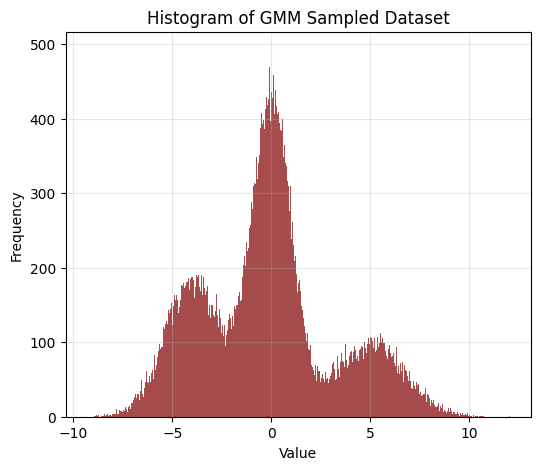

In [12]:
### Solution ###
plt.figure(figsize=(6,5))
plt.hist(X, bins=1000, color='maroon', alpha=0.7)
plt.title('Histogram of GMM Sampled Dataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

## EM algorithm

It is time to start coding up the EM algorithm from scratch. We will break this down into five stages:

- Initialization
- E-step
- M-step
- Stopping criterion
- Algorithm

For each of the first four stages, we will write functions that are related to that stage. All these functions will be eventually used in the code for the EM algorithm. This is a modular approach to writing the code. We have identified four blocks or stages. We can independently work on these four blocks and finally combine them. If something goes wrong, we can quickly localize the problem to one of these four blocks.


## Problem-5

Write a function `init` that initializes the parameters of the GMM and returns `theta_0`, a NumPy array of shape $(3K, )$. The first $K$ elements of `theta_0` ($\boldsymbol{\theta}^{(0)}$) represents the means of the three mixtures, the next $K$ represent the variances and the last $K$ represent the mixture probabilities.

The exact values to be used are as follows:

- $\mu_0 = 1, \mu_1 = 2, \mu_2 = 3$
- $\sigma_0^2 = \sigma_1^2 = \sigma_2^2 = 1$
- $\pi_0 = \pi_1 = \pi_2 = 1/3$

Enter $||\boldsymbol{\theta}^{(0)}||$ as your answer correct to two decimal places. Keep this variable `theta_0` as it will be used in subsequent problems.

In [14]:
### Solution ###
def init():
  means = [1, 2, 3]
  variances = [1, 1, 1]
  probabilities = [0.33, 0.33, 0.33]

  theta_0 = np.concatenate([means, variances, probabilities])
  return theta_0

theta_0 = init()
norm_theta_0 = np.linalg.norm(theta_0)
print(norm_theta_0)

4.16253528513573


## Problem-6

Write a function `estep` that accepts `theta` and `X` as arguments. It should perform the E-step and return an array `lamb` of shape `(n, K)`. The element `lamb[i][k]` is equal to $\lambda_k^{i}$. For the purposes of evaluation, run the function on `theta_0` and `X`. Call the returned value `lamb_1`.  Compute the sum of the zeroth column of the matrix `lamb_1` and enter that as your answer correct to two decimal places. Keep this variable `lamb_1` as it will be used in subsequent problems.


**Aside**: We prefer the variable name `lamb` over `lambda` for a reason. Can you guess why?

---

$$
\lambda_k^{i} = \frac{\pi_k \mathcal{N}(x_i|\mu_k, \sigma_k^2)}{\sum_{j=0}^{K-1} \pi_j \mathcal{N}(x_j|\mu_j, \sigma_j^2)}
$$

### Intuition -
- $\lambda_k^{i}$ represents the probability that the data point $x_i$ belongs to the $k$-th Gaussian component
- The numerator $\mathcal{N}(x_i |\mu_i, \sigma_i^2)$ is the weighted likelihood of the data point $x_i$ under the $k$-th Gaussian.

$$
\mathcal{N}(x_i | \mu_k, \sigma_k^2) = \frac{1}{\sqrt{2 \pi}\sigma_k}{\exp\left(\frac{-(x_i - \mu_k)^2}{2 \sigma_k^2} \right)}
$$

- The denominator is the total likelihood of the data point $x_i$ under all Gaussian components in the mixture, ensuring that the responsibilities sum to 1.


In [15]:
### Solution ###
def gaussian_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def estep(theta, X):
  K = len(theta) // 3
  means = theta[:K]
  variances = theta[K:2*K]
  probabilities = theta[2*K:]
  n = X.shape[0]                # Number of data points
  lamb = np.zeros((n, K))       # Responsibility matrix

  for i in range(n):
    denominator = 0
    for k in range(K):
        denominator += probabilities[k] * gaussian_pdf(X[i], means[k], np.sqrt(variances[k]))

    for k in range(K):
        numerator = probabilities[k] * gaussian_pdf(X[i], means[k], np.sqrt(variances[k]))
        lamb[i, k] = numerator / denominator

  return lamb

lamb_1 = estep(theta_0, X)
np.sum(lamb_1[:, 0])

68226.19649822346

## Problem-7

Write a function `mstep` that accepts `lamb` and `X` as arguments. It should perform the M-step and return a NumPy array `theta`, the updated parameters, namely. We follow the same convention for storing the parameters as was done during the init step. For the purposes of evaluation, compute the value of the function for `lamb_1` and `X`. Call the returned value `theta_1` ($\boldsymbol{\theta}^{(1)}$). Enter $||\boldsymbol{\theta}^{(1)}||$  as your answer correct to two decimal places.

---

### Formulae
1. $$
      \mu_k = \frac{\sum_{i=0}^{n-1}\lambda_k^i x_i}{\sum_{i=0}^{n-1}\lambda_k^i}
   $$

2. $$
      \sigma_k^2 = \frac{\sum_{i=0}^{n-1}\lambda_k^i(x_i - \mu_k)^2}{\sum_{i=0}^{n-1}\lambda_k^i}
   $$

3. $$
      \pi_k = \frac{\sum_{i=0}^{n-1}\lambda_k^i}{n}
   $$

In [16]:
### Solution ###
def mstep(lamb, X):
    n, K = lamb.shape
    mu = np.zeros(K)
    sigma2 = np.zeros(K)
    pi = np.zeros(K)

    for k in range(K):
        mu[k] = np.sum(lamb[:, k] * X) / np.sum(lamb[:, k])                         # Update means
        sigma2[k] = np.sum(lamb[:, k] * (X - mu[k]) ** 2) / np.sum(lamb[:, k])      # Update variances
        pi[k] = np.sum(lamb[:, k]) / n                                              # Update mixture probabilities

    theta = np.concatenate([mu, sigma2, pi])
    return theta

theta_1 = mstep(lamb_1, X)
theta_1_norm = np.linalg.norm(theta_1)
print(f"||θ(1)|| = {theta_1_norm:.2f}")

||θ(1)|| = 8.69


## Problem-8

Given two vectors $\boldsymbol{\theta}^{(t)}$ and $\boldsymbol{\theta}^{(t + 1)}$, write a function `distance` that accepts these two vectors as arguments and returns the distance between them:

$$
||\boldsymbol{\theta}^{(t + 1)} - \boldsymbol{\theta}^{(t)}||
$$

For the purposes of evaluation, compute the distance between $\boldsymbol{\theta}^{(0)}$ and $\boldsymbol{\theta}^{(1)}$ and report your answer correct to two decimal places.

In [17]:
### Solution ###
def distance(theta_t, theta_t1):
    return np.linalg.norm(theta_t1 - theta_t)

dist = distance(theta_0, theta_1)
print(dist)

6.266761815755878


## Problem-9

Perform the EM algorithm until convergence. The stopping-criterion is that the distance between the two parameter-vectors should be less than $0.01$.

$$
||\boldsymbol{\theta}^{(t + 1)} - \boldsymbol{\theta}^{(t)}|| < 0.01
$$


Initialize the parameters to $\boldsymbol{\theta}^{(0)}$. Find the number of iterations it takes for the algorithm to converge. Enter this as your answer.

This is going to take some time. Hold tight!

In [19]:
### Solution ###
theta_0 = init()
theta_t = theta_0
t = 0
tolerance = 0.01

while True:
    lamb = estep(theta_t, X)              # Perform E-step
    theta_t1 = mstep(lamb, X)             # Perform M-step

    dist = distance(theta_t, theta_t1)    # Compute the distance
    t += 1

    if dist < tolerance:    # Check convergence
        break

    theta_t = theta_t1      # Update theta

print(t)

72


## Problem-10

Let us now verify the correctness of our algorithm. We know the true parameters here:

$$
\boldsymbol{\theta} = \begin{bmatrix}
-4\\
0\\
5\\
2\\
1\\
3\\
0.3\\
0.5\\
0.2
\end{bmatrix}
$$

Let $\boldsymbol{\theta}^{*}$ be the parameter at convergence. Compute the distance between this vector and the true parameter vector. Enter your answer correct to two decimal places. The smaller the distance, better our estimate.

In [20]:
### Solution ###
theta_true = np.array([-4, 0, 5, 2, 1, 3, 0.3, 0.5, 0.2])
distance_to_true = distance(theta_t, theta_true)
print(distance_to_true)

0.11146156589050893


## Problem-11

We shall do a hard clustering of the data-points. Use the final `lamb` value obtained and cluster the points using:

$$
z_i = \operatorname*{argmax} \limits_{k} \lambda_k^{i}
$$

Let $0$, $1$ and $2$ correspond to the colors red, blue and green respectively. Plot three colored histograms on the same figure, one for each cluster.

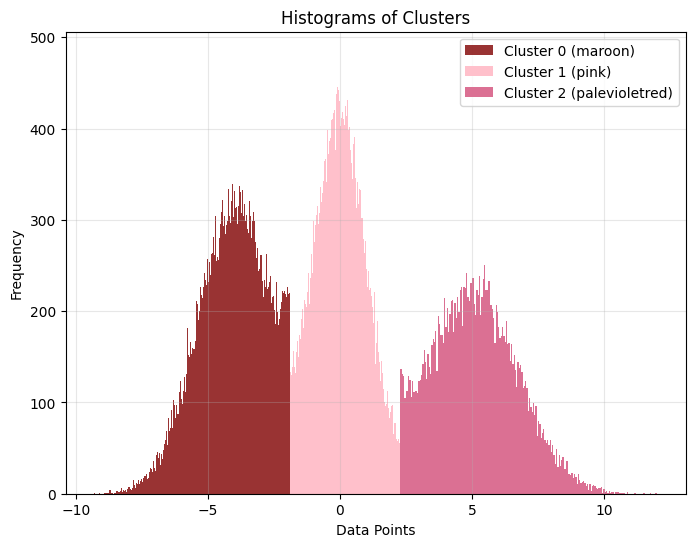

In [41]:
### Solution ###
# Hard clustering
z = np.argmax(lamb, axis=1)  # Assign cluster based on maximum λ_ik for each data point

# Split data by cluster
cluster_0 = X[z == 0]
cluster_1 = X[z == 1]
cluster_2 = X[z == 2]

# Plot histograms
plt.figure(figsize=(8, 6))
plt.hist(cluster_0, bins=200, alpha = 0.8, color='maroon', label='Cluster 0 (maroon)')
plt.hist(cluster_1, bins=200, color='pink', label='Cluster 1 (pink)')
plt.hist(cluster_2, bins=200, color='palevioletred', label='Cluster 2 (palevioletred)')

# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Frequency')
plt.title('Histograms of Clusters')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Extras

Here are some of the things that can be tried out:

- Make the stopping criterion more stringent and see the effect it has on the number of iterations
- Change the size of the dataset and study the effect it has on convergence.
- Change the initialization and study the effect it has on convergence
- Change the number of mixtures and see what happens